# 基于backtrader实现高效的多因子策略（多股）


## 数据介绍

包含了一下五张表
[('xjllb',), ('zcfzb',), ('lrb',), ('cwzbsj',), ('stock_daily',)]

其中stock_daily包含了上证2千多只股票2018年1月——2023年2月的所有日线数据

此数据是淘宝花了几十块钱买的，为了减少体积减少了年份与股票数

其实也可以通过akshare爬取，如果需要更新数据建议自行爬取并写入数据库

## sqlite3的基本操作

* 数据库的连接 ：sqlite3.connect(r'F:\量化金融\stock_2018.db')

* 数据库命令的执行：c.execute("select name from sqlite_master where type='table'")

* pandas下的数据库操作：读pd.read_sql；写z1.to_sql('stock_daily',conn,if_exists="append")

In [1]:
import sqlite3
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
conn=sqlite3.connect(r'F:\量化金融\stock_2018.db')

In [3]:
#获取数据库中的表
c = conn.cursor()
c.execute("select name from sqlite_master where type='table'")
tab_name=c.fetchall()
tab_name

[('xjllb',), ('zcfzb',), ('lrb',), ('cwzbsj',), ('stock_daily',)]

In [5]:
stock_daily0=pd.read_sql("select * from stock_daily where 股票代码='000004.SZ'",con=conn)

In [7]:
stock_daily0.head(3)

,index,交易日期,股票代码,股票简称,开盘价,最高价,最低价,收盘价,成交量(手),成交额(千元),...,市盈率(动态),市净率,市销率,市销率(TTM),股息率(%),股息率(TTM)(%),总股本(万股),流通股本(万股),总市值(万元),流通市值(万元)
0,6206,20180102,000004.SZ,国农科技,90.5866,91.3994,89.4080,90.7898,6261.81,13951.004,...,0.0,16.2585,6.5215,13.2958,0.0,None,8397.6684,8296.3684,187603.9121,185340.8701
1,6207,20180103,000004.SZ,国农科技,91.1149,97.0890,90.5053,96.7232,18795.39,43218.416,...,0.0,17.3210,6.9477,14.1647,0.0,None,8397.6684,8296.3684,199864.5079,197453.5679
2,6208,20180104,000004.SZ,国农科技,96.7232,96.8451,93.9597,94.4474,14540.66,33908.548,...,0.0,16.9135,6.7842,13.8314,0.0,None,8397.6684,8296.3684,195161.8136,192807.6016


## 最简单的多股策略


### 完成数据的处理函数，输出符合backtrade要求的单股数据

In [3]:
stock_daily=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)

In [9]:
stock_daily.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [4]:
stock_daily.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)']

In [5]:
stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64")

In [6]:
stock_daily.set_index("date",inplace=True,drop=False)

In [7]:
stock_daily["openinterest"]=0

In [15]:
syboml='003001.SZ'

In [16]:
stock_daily[stock_daily["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]

,open,high,low,close,volume,openinterest
date,,,,,,
2020-10-13,36.1900,43.4300,36.1900,43.4300,1755.12,0
2020-10-14,47.7700,47.7700,44.0100,47.7700,109022.37,0
2020-10-15,46.4400,46.8000,43.0400,43.0900,81268.36,0
2020-10-16,41.0200,43.8900,40.1100,41.9400,57613.41,0
2020-10-19,41.1300,41.8000,39.2500,39.4500,47553.71,0
...,...,...,...,...,...,...
2023-02-13,21.5354,21.9188,21.3635,21.6279,16280.00,0
2023-02-14,21.6808,21.8130,21.4561,21.5618,11786.54,0
2023-02-15,21.6676,21.7337,21.4693,21.6411,11087.41,0


In [17]:
def get_data_0(syboml):
    return stock_daily[stock_daily["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]

In [18]:
get_data_0('003002.SZ')

,open,high,low,close,volume,openinterest
date,,,,,,
2020-09-22,9.8600,11.8400,9.8600,11.8400,2659.25,0
2020-09-23,13.0200,13.0200,13.0200,13.0200,720.01,0
2020-09-24,14.3200,14.3200,14.3200,14.3200,708.18,0
2020-09-25,15.7500,15.7500,14.3200,15.0100,243874.54,0
2020-09-28,14.0000,14.2900,13.5100,13.5100,154086.31,0
...,...,...,...,...,...,...
2023-02-13,22.9680,23.5944,22.9158,23.3647,31574.99,0
2023-02-14,23.3647,23.8241,23.0515,23.7928,28641.55,0
2023-02-15,23.7614,24.1268,23.6153,23.8972,24071.00,0


In [19]:
len(stock_daily["股票代码"].unique())

1294

In [9]:
#stock_daily.head()

### 通过循环让策略读入多个股票数据

In [21]:
#这是读入一个股票数据的策略，请改写为多个股票读入
def huice_run(start,end,stock_list,strategy):

    cerebro = bt.Cerebro()
    for i in stock_list:
        stock=get_data_0(i)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
        
    cerebro.addstrategy(strategy) 
    cerebro.broker.setcash(100000) 
    cerebro.broker.setcommission(commission=0.002) 


    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return cerebro

## 多股策略的买入

1，选择最开始的一只股票买入

2，选择特定股票买入

3，等比买入所有股票

In [34]:
#原始事件策略模板，请基于此改写
class my_strategy_date(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        if str(self.datetime.date(0)) in sell_date.keys(): 
            s_list=sell_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
                
        if str(self.datetime.date(0)) in buy_date.keys(): 
            s_list=buy_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

            
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

In [25]:
#get_data_0('003003.SZ').tail(20)

In [29]:
start=datetime(2020,9,22)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}
#buy_date=[datetime(2020, 9, 22).date()]
#sell_date=[]

In [102]:
buy_date.keys()

dict_keys(['2020-09-22'])

In [30]:
result=huice_run(start,end,stock_list,my_strategy_date)

2020-09-22 2023-02-10
初始资金: 100000.00
2020-09-23, 买入003002.SZ, 成交量3800，成交价13.02
2020-09-23, 买入003003.SZ, 成交量2707，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-3800，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-2707，成交价12.09
最终资金: 112731.75
夏普比率: OrderedDict([('sharperatio', 0.1949083238190227)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.111117263713433), ('moneydown', 9950.936514), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.599755296618), ('moneydown', 56371.585799999986)]))])


<IPython.core.display.Javascript object>


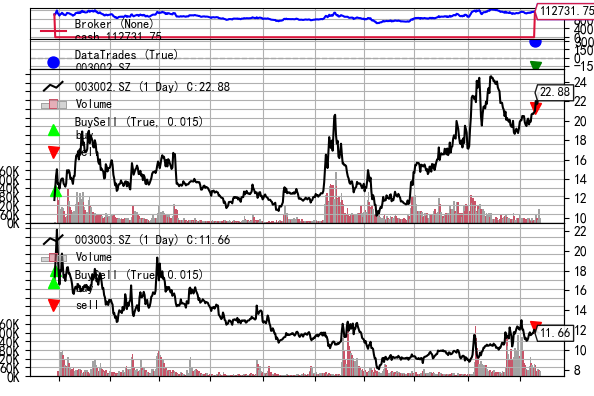

[[<Figure size 432x288 with 6 Axes>]]

In [16]:
result.plot()

## 多因子选股的策略框架搭建


### 以时间为键，股票id列表为值的交易模板搭建

In [121]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}

In [124]:
#result=huice_run(start,end,stock_list,my_strategy_date)

In [114]:
get_data_0("003002.SZ")

,open,high,low,close,volume,openinterest
date,,,,,,
2020-09-22,9.8600,11.8400,9.8600,11.8400,2659.25,0
2020-09-23,13.0200,13.0200,13.0200,13.0200,720.01,0
2020-09-24,14.3200,14.3200,14.3200,14.3200,708.18,0
2020-09-25,15.7500,15.7500,14.3200,15.0100,243874.54,0
2020-09-28,14.0000,14.2900,13.5100,13.5100,154086.31,0
...,...,...,...,...,...,...
2023-02-13,22.9680,23.5944,22.9158,23.3647,31574.99,0
2023-02-14,23.3647,23.8241,23.0515,23.7928,28641.55,0
2023-02-15,23.7614,24.1268,23.6153,23.8972,24071.00,0


### 对齐导入的不同股票数据，并填补数据中的空值

In [38]:
stock_daily.date.unique()

array(['2020-10-13T00:00:00.000000000', '2020-10-14T00:00:00.000000000',
       '2020-10-15T00:00:00.000000000', ...,
       '2019-08-21T00:00:00.000000000', '2019-08-22T00:00:00.000000000',
       '2019-08-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
n1=len(stock_daily.date.unique())

In [10]:
z1=pd.Series(range(0,n1),index=stock_daily.date.unique()).sort_index()

In [11]:
z1

2018-01-02    843
2018-01-03    844
2018-01-04    845
2018-01-05    846
2018-01-08    847
             ... 
2023-02-13    567
2023-02-14    568
2023-02-15    569
2023-02-16    570
2023-02-17    571
Length: 1244, dtype: int64

In [136]:
pd.concat([get_data_0("003002.SZ"),z1],axis=1).fillna(method="bfill").fillna(method="ffill")

,open,high,low,close,volume,openinterest,0
2018-01-02,9.8600,11.8400,9.8600,11.8400,2659.25,0.0,843
2018-01-03,9.8600,11.8400,9.8600,11.8400,2659.25,0.0,844
2018-01-04,9.8600,11.8400,9.8600,11.8400,2659.25,0.0,845
2018-01-05,9.8600,11.8400,9.8600,11.8400,2659.25,0.0,846
2018-01-08,9.8600,11.8400,9.8600,11.8400,2659.25,0.0,847
...,...,...,...,...,...,...,...
2023-02-13,22.9680,23.5944,22.9158,23.3647,31574.99,0.0,567
2023-02-14,23.3647,23.8241,23.0515,23.7928,28641.55,0.0,568
2023-02-15,23.7614,24.1268,23.6153,23.8972,24071.00,0.0,569
2023-02-16,23.6988,23.7823,22.6548,23.3856,43760.12,0.0,570


In [43]:
def get_data_1(syboml):
    stock=stock_daily[stock_daily["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,z1],axis=1).fillna(method="bfill").fillna(method="ffill")
#    stock=pd.concat([get_data_0("003002.SZ"),z1],axis=1).fillna(method="bfill").fillna(method="ffill")
    return stock[["open","high","low","close","volume","openinterest"]]

In [44]:
#这是读入一个股票数据的策略，请改写为多个股票读入
def huice_run_num(start,end,stock_list,strategy):

    cerebro = bt.Cerebro()
    for i in stock_list:
        stock=get_data_1(i)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
        
    cerebro.addstrategy(strategy) 
    cerebro.broker.setcash(100000) 
    cerebro.broker.setcommission(commission=0.002) 


    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return cerebro

In [45]:
#原始事件策略模板，请基于此改写
class my_strategy_date_1(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        if str(self.datetime.date(0)) in sell_date.keys(): 
            s_list=sell_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in buy_date.keys(): 
            s_list=buy_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

            
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

In [36]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}

In [41]:
result=huice_run_num(start,end,stock_list,my_strategy_date_1)

2018-02-22 2023-02-10
初始资金: 100000.00
2020-09-23, 买入003002.SZ, 成交量3800，成交价13.02
2020-09-23, 买入003003.SZ, 成交量2707，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-3800，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-2707，成交价12.09
最终资金: 112731.75
夏普比率: OrderedDict([('sharperatio', 0.13880099293497766)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.111117263713433), ('moneydown', 9950.936514), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.599755296618), ('moneydown', 56371.585799999986)]))])


## 单因子策略

### 市值

市值，是指一家上市公司的发行股份按市场价格计算出来的股票总价值，其计算方法为每股股票的市场价格乘以发行总股数。整个股市上所有上市公司的市值总和，即为股票总市值。

* 以某个时间段为周期，基于市值因子排序选择特定股票买入和抛出

In [22]:
time_30=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]

In [28]:
stock_daily[stock_daily.date==time_30[0]].sort_values(by="总市值(万元)").head(5)["股票代码"].tolist()

['300684.SZ', '300029.SZ', '300106.SZ', '300354.SZ', '300028.SZ']

In [29]:
stock_daily[stock_daily.date==time_30[1]].sort_values(by="总市值(万元)").head(5)["股票代码"].tolist()

['300106.SZ', '300028.SZ', '300354.SZ', '300029.SZ', '300489.SZ']

In [47]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest'],
      dtype='object')

In [49]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)

In [36]:
time_30=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in time_30:
    buy_list=stock_daily[stock_daily.date==i].sort_values(by="总市值(万元)").head(5)["股票代码"].tolist()
    buy_date.update({str(i.date()):buy_list})
    sell_list=list(postion-set(buy_list))
    sell_date.update({str(i.date()):sell_list})
    postion=set(buy_list)
    stock_list=stock_list|set(buy_list)
stock_list=list(stock_list)

In [53]:
#buy_date

In [51]:
result=huice_run_num(start,end,stock_list,my_strategy_date_1)

2018-01-02 2023-02-10
初始资金: 100000.00
2018-01-03, 买入300684.SZ, 成交量1174，成交价16.86
2018-01-03, 买入300029.SZ, 成交量2294，成交价7.86
2018-01-03, 买入300106.SZ, 成交量1497，成交价12.03
2018-01-03, 买入300354.SZ, 成交量443，成交价40.60
2018-01-03, 买入300028.SZ, 成交量1437，成交价12.62
2018-02-14, 卖出300684.SZ, 成交量-1174，成交价39.98
2018-02-14, 买入300106.SZ, 成交量640，成交价9.47
2018-02-14, 买入300028.SZ, 成交量670，成交价9.60
2018-02-14, 买入300354.SZ, 成交量196，成交价31.57
2018-02-14, 买入300029.SZ, 成交量577，成交价7.11
2018-02-14, 买入300489.SZ, 成交量659，成交价31.56
2018-04-04, 卖出300354.SZ, 成交量-639，成交价44.34
2018-04-04, 买入300106.SZ, 成交量131，成交价10.29
2018-04-04, 买入300028.SZ, 成交量106，成交价10.40
2018-04-04, 买入300321.SZ, 成交量634，成交价36.82
2018-04-04, 卖出300029.SZ, 成交量-114，成交价8.39
2018-05-22, 卖出300489.SZ, 成交量-659，成交价36.05
2018-05-22, 买入300106.SZ, 成交量35，成交价10.16
2018-05-22, 买入300029.SZ, 成交量313，成交价7.53
2018-05-22, 卖出300028.SZ, 成交量-47，成交价10.74
2018-05-22, 买入300354.SZ, 成交量614，成交价37.70
2018-07-04, 卖出300354.SZ, 成交量-614，成交价31.60
2018-07-04, 买入300028.SZ, 成交量1727，成交价4.03
2018-07-04, 卖出30

2022-06-20, 卖出300309.SZ, 成交量-1380，成交价13.14
2022-06-20, 卖出300356.SZ, 成交量-1656，成交价7.58
2022-06-20, 卖出300336.SZ, 成交量-1440，成交价11.07
2022-06-20, 卖出300495.SZ, 成交量-1120，成交价18.61
2022-06-20, 卖出300338.SZ, 成交量-934，成交价12.40
2022-06-20, 买入300312.SZ, 成交量14496，成交价1.09
2022-06-20, 买入300178.SZ, 成交量15744，成交价1.00
2022-06-20, 买入300325.SZ, 成交量5499，成交价2.88
2022-06-20, 买入300202.SZ, 成交量3753，成交价4.35
2022-06-20, 买入300367.SZ, 成交量2974，成交价5.32
2022-08-01, 卖出300312.SZ, 成交量-14496，成交价0.97
2022-08-01, 卖出300367.SZ, 成交量-2974，成交价5.14
2022-08-01, 卖出300325.SZ, 成交量-5499，成交价2.36
2022-08-01, 卖出300202.SZ, 成交量-3753，成交价3.47
2022-08-01, 卖出300178.SZ, 成交量-15744，成交价1.00
2022-08-01, 买入300338.SZ, 成交量1099，成交价12.75
2022-08-01, 买入300356.SZ, 成交量1425，成交价9.88
2022-08-01, 买入300392.SZ, 成交量773，成交价17.94
2022-08-01, 买入300282.SZ, 成交量969，成交价14.31
2022-08-01, 买入300336.SZ, 成交量1280，成交价10.94
2022-09-13, 卖出300336.SZ, 成交量-1280，成交价12.86
2022-09-13, 卖出300356.SZ, 成交量-1425，成交价14.01
2022-09-13, 买入300330.SZ, 成交量1328，成交价13.20
2022-09-13, 买入300392.SZ, 成交量68，成交

In [38]:
len(stock_list)

47

In [41]:
#buy_date

In [54]:
stock_daily[['股票代码','市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',]].head(200)

,股票代码,市盈率(静态),市盈率(TTM),市盈率(动态)
date,,,,
2020-10-13,003001.SZ,32.8391,31.8466,32.47
2020-10-14,003001.SZ,36.1208,35.0291,35.71
2020-10-15,003001.SZ,32.5820,31.5973,32.21
2020-10-16,003001.SZ,31.7125,30.7540,31.35
2020-10-19,003001.SZ,29.8297,28.9281,29.49
...,...,...,...,...
2021-07-28,003001.SZ,26.3160,25.5447,42.18
2021-07-29,003001.SZ,26.4421,25.6672,42.38
2021-07-30,003001.SZ,27.0224,26.2305,43.31


In [29]:
date0=stock_daily.date.unique()[::30][0]
stock_daily[stock_daily["date"]==date0].sort_values(by="总市值(万元)").head(5)["股票代码"].tolist()

['300431.SZ', '300029.SZ', '300665.SZ', '300446.SZ', '300478.SZ']

In [43]:
time_id=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]

In [61]:
str(time_id[0].date())

'2018-01-02'

In [158]:
stock_daily[stock_daily["date"]==time_id[0]].sort_values(by="总市值(万元)").head(5)["股票代码"].tolist()

['300684.SZ', '300029.SZ', '300106.SZ', '300354.SZ', '300028.SZ']

In [33]:
stock_list=list(stock_list)

In [59]:
len(stock_list)

44

### 市盈率

https://baike.baidu.com/item/%E5%B8%82%E7%9B%88%E7%8E%87/90136?fr=aladdin

市盈率亦称本益比，是股票价格除以每股盈利的比率。市场广泛谈及市盈率通常指的是静态市盈率，通常用来作为比较不同价格的股票是否被高估或者低估的指标。市盈率反映了在每股盈利不变的情况下，当派息率为100%，并且所得股息没有进行再投资的条件下，经过多少年投资可以通过股息全部收回。一般情况下，一只股票市盈率越低，市价相对于股票的盈利能力越低，表明投资回收期越短，投资风险就越小，股票的投资价值就越大；反之则结论相反。

市盈率分为静态市盈率与动态市盈率。静态市盈率被广泛谈及也是人们通常所指，但更应关注与研究动态市盈率。市场广泛谈及的市盈率通常指的是静态市盈率，这给投资人的决策带来了许多盲点和误区。毕竟过去的并不能充分说明未来，而投资股票更多的是看未来！

动态市盈率的计算公式是以静态市盈率为基数，乘以动态系数。该系数为1÷(1+i)n，其中i为企业每股收益的增长性比率，n为企业可持续发展的存续期。比如说，上市公司目前股价为20元，每股收益为0.38元，去年同期每股收益为0.28元，成长性i为35%，该企业未来保持该增长速度的时间n可持续5年，则动态系数为1÷(1+35%)5=22%。相应地，动态市盈率为11.6倍[即：52（静态市盈率：20元÷0.38元=52）×22%]。两者相比，差别之大，相信普通投资人看了会大吃一惊，恍然大悟。动态市盈率理论告诉一个简单朴素而又深刻的道理，即投资股市一定要选择有持续成长性的公司。因此不难理解资产重组为什么会成为市场永恒的主题，以及有些业绩不好的公司在实质性的重组题材支撑下成为市场黑马 。

* ttm市盈率，静态市盈率和动态市盈率计算方法比较

ttm市盈率是滚动市盈率，一般是指市盈率在一定的考察期内，即12个月，计算方法：市盈率＝普通股每股市场价格／普通股每年每股盈利。比如，某上市公司的普通每股市场价格为20，其普通股每年每股盈利0.5元，则其ttm市盈率＝20／0.5＝40。

除了ttm市盈率之外，还存在静态市盈率和动态市盈率，其中静态市盈率一般指市场中所使用的市盈率，是指以股票的目前价格与当前每股预期收益之比，即静态市盈率＝股票现价／当前预期收益，体现的是企业按现在的盈利水平要多久才能回本，是衡量股票预期收益与风险的重要指标，一般是较低越好，但一些特殊情况下，静态市盈率较高也合理，这时需要投资者对比同行行业，企业发展阶段。

动态市盈率是指股票现价与全年预估每股预期收益之比，即动态市盈率＝股票现价／全年预估每股预期收益，或者，动态市盈率＝静态市盈率／（1＋i）＾n其中i代表年增长率，n代表年份。动态市盈率反映公司的可持续发展能力。

* 基于市盈率做因子策略

In [55]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest'],
      dtype='object')

In [59]:
time_30=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in time_30:
    buy_list=stock_daily[stock_daily.date==i].sort_values(by="市盈率(静态)",ascending=False).head(5)["股票代码"].tolist()
    buy_date.update({str(i.date()):buy_list})
    sell_list=list(postion-set(buy_list))
    sell_date.update({str(i.date()):sell_list})
    postion=set(buy_list)
    stock_list=stock_list|set(buy_list)
stock_list=list(stock_list)

In [57]:
len(stock_list)

41

In [60]:
result=huice_run_num(start,end,stock_list,my_strategy_date_1)

2018-01-02 2023-02-10
初始资金: 100000.00
2018-01-03, 买入300308.SZ, 成交量92，成交价194.85
2018-01-03, 买入300280.SZ, 成交量495，成交价36.37
2018-01-03, 买入300122.SZ, 成交量151，成交价118.93
2018-01-03, 买入300404.SZ, 成交量434，成交价41.18
2018-01-03, 买入300338.SZ, 成交量195，成交价92.17
2018-02-14, 卖出300280.SZ, 成交量-495，成交价30.32
2018-02-14, 卖出300308.SZ, 成交量-13，成交价200.60
2018-02-14, 卖出300122.SZ, 成交量-6，成交价110.40
2018-02-14, 买入300338.SZ, 成交量10，成交价77.16
2018-02-14, 买入300404.SZ, 成交量142，成交价27.23
2018-02-14, 买入300354.SZ, 成交量498，成交价31.57
2018-04-04, 卖出300122.SZ, 成交量-145，成交价139.82
2018-04-04, 买入300308.SZ, 成交量2，成交价250.95
2018-04-04, 卖出300404.SZ, 成交量-121，成交价44.38
2018-04-04, 买入300338.SZ, 成交量33，成交价82.86
2018-04-04, 卖出300354.SZ, 成交量-19，成交价44.34
2018-04-04, 买入300223.SZ, 成交量266，成交价74.33
2018-05-22, 卖出300404.SZ, 成交量-455，成交价44.20
2018-05-22, 卖出300308.SZ, 成交量-81，成交价248.31
2018-05-22, 卖出300354.SZ, 成交量-479，成交价37.70
2018-05-22, 卖出300338.SZ, 成交量-238，成交价84.62
2018-05-22, 买入300268.SZ, 成交量539，成交价34.74
2018-05-22, 买入300223.SZ, 成交量30，成交价65.36
2018-05-22, 买

2022-05-06, 卖出300077.SZ, 成交量-425，成交价73.12
2022-05-06, 卖出300318.SZ, 成交量-854，成交价38.79
2022-05-06, 卖出300700.SZ, 成交量-1774，成交价23.07
2022-05-06, 卖出300534.SZ, 成交量-866，成交价30.72
2022-05-06, 卖出300479.SZ, 成交量-744，成交价35.45
2022-05-06, 买入300353.SZ, 成交量714，成交价46.07
2022-05-06, 买入300799.SZ, 成交量583，成交价55.88
2022-05-06, 买入300446.SZ, 成交量811，成交价40.28
2022-05-06, 买入300471.SZ, 成交量502，成交价65.23
2022-05-06, 买入300937.SZ, 成交量1151，成交价28.41
2022-06-20, 卖出300937.SZ, 成交量-1151，成交价29.99
2022-06-20, 卖出300446.SZ, 成交量-811，成交价42.81
2022-06-20, 卖出300799.SZ, 成交量-142，成交价92.23
2022-06-20, 卖出300353.SZ, 成交量-22，成交价60.66
2022-06-20, 买入300345.SZ, 成交量1484，成交价27.23
2022-06-20, 卖出300471.SZ, 成交量-20，成交价85.12
2022-06-20, 买入300105.SZ, 成交量1105，成交价36.86
2022-08-01, 卖出300799.SZ, 成交量-15，成交价107.46
2022-08-01, 买入300353.SZ, 成交量87，成交价57.85
2022-08-01, 卖出300345.SZ, 成交量-160，成交价34.03
2022-08-01, 卖出300105.SZ, 成交量-90，成交价43.41
2022-08-01, 买入300471.SZ, 成交量43，成交价85.95
2022-09-13, 卖出300471.SZ, 成交量-525，成交价79.74
2022-09-13, 卖出300799.SZ, 成交量-6，成交价115.74
20

## 多因子策略框架

* 以"总市值(万元)"与'市盈率(静态)'两个因子分别排序，然后各自排序的顺序号相加，得到的和再次排序，以30天为周期选择排名前列的股票买入

In [69]:
foctor_sz=stock_daily[stock_daily["date"]==time_30[0]].sort_values(by="总市值(万元)")["股票代码"].tolist()
f_sz_df=pd.Series(range(1,len(foctor_sz)+1),index=foctor_sz)
f_sz_df

300684.SZ      1
300029.SZ      2
300106.SZ      3
300354.SZ      4
300028.SZ      5
            ... 
300059.SZ    659
300072.SZ    660
300433.SZ    661
300676.SZ    662
300498.SZ    663
Length: 663, dtype: int64

In [70]:
foctor_syl=stock_daily[stock_daily["date"]==time_30[0]].sort_values(by="市盈率(静态)",ascending=False)["股票代码"].tolist()
f_syl_df=pd.Series(range(1,len(foctor_syl)+1),index=foctor_syl)
f_syl_df

300308.SZ      1
300280.SZ      2
300122.SZ      3
300404.SZ      4
300338.SZ      5
            ... 
300330.SZ    659
300380.SZ    660
300397.SZ    661
300402.SZ    662
300486.SZ    663
Length: 663, dtype: int64

In [72]:
f_syl_sz=pd.concat([f_sz_df,f_syl_df],axis=1)

In [75]:
f_syl_sz[2]=f_syl_sz[0]+f_syl_sz[1]

In [80]:
f_syl_sz.sort_values(by=2).head(5).index.tolist()

['300354.SZ', '300211.SZ', '300126.SZ', '300442.SZ', '300093.SZ']

In [81]:
time_30=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in time_30:
    foctor_sz=stock_daily[stock_daily["date"]==i].sort_values(by="总市值(万元)")["股票代码"].tolist()
    f_sz_df=pd.Series(range(1,len(foctor_sz)+1),index=foctor_sz)
    foctor_syl=stock_daily[stock_daily["date"]==i].sort_values(by="市盈率(静态)",ascending=False)["股票代码"].tolist()
    f_syl_df=pd.Series(range(1,len(foctor_syl)+1),index=foctor_syl)
    f_syl_sz=pd.concat([f_sz_df,f_syl_df],axis=1)
    f_syl_sz[2]=f_syl_sz[0]+f_syl_sz[1]
    
    buy_list=f_syl_sz.sort_values(by=2).head(5).index.tolist()
    buy_date.update({str(i.date()):buy_list})
    sell_list=list(postion-set(buy_list))
    sell_date.update({str(i.date()):sell_list})
    postion=set(buy_list)
    stock_list=stock_list|set(buy_list)
    
stock_list=list(stock_list)

In [83]:
len(stock_list)

35

In [84]:
result=huice_run_num(start,end,stock_list,my_strategy_date_1)

2018-01-02 2023-02-10
初始资金: 100000.00
2018-01-03, 买入300354.SZ, 成交量443，成交价40.60
2018-01-03, 买入300211.SZ, 成交量400，成交价45.04
2018-01-03, 买入300126.SZ, 成交量677，成交价26.50
2018-01-03, 买入300442.SZ, 成交量835，成交价21.67
2018-01-03, 买入300093.SZ, 成交量871，成交价20.68
2018-02-14, 卖出300211.SZ, 成交量-400，成交价38.53
2018-02-14, 卖出300442.SZ, 成交量-835，成交价17.59
2018-02-14, 买入300354.SZ, 成交量19，成交价31.57
2018-02-14, 买入300220.SZ, 成交量331，成交价43.67
2018-02-14, 买入300093.SZ, 成交量133，成交价14.65
2018-02-14, 买入300404.SZ, 成交量535，成交价27.23
2018-02-14, 卖出300126.SZ, 成交量-4，成交价21.53
2018-04-04, 卖出300404.SZ, 成交量-535，成交价44.38
2018-04-04, 卖出300220.SZ, 成交量-331，成交价52.17
2018-04-04, 卖出300354.SZ, 成交量-27，成交价44.34
2018-04-04, 买入300093.SZ, 成交量120，成交价16.09
2018-04-04, 买入300092.SZ, 成交量940，成交价19.34
2018-04-04, 买入300211.SZ, 成交量427，成交价42.51
2018-04-04, 买入300126.SZ, 成交量74，成交价24.04
2018-05-22, 卖出300093.SZ, 成交量-1124，成交价15.87
2018-05-22, 买入300354.SZ, 成交量37，成交价37.70
2018-05-22, 买入300126.SZ, 成交量25，成交价22.84
2018-05-22, 买入300330.SZ, 成交量786，成交价22.84
2018-05-22, 卖出3002

2022-03-18, 卖出300330.SZ, 成交量-2928，成交价26.09
2022-03-18, 买入300555.SZ, 成交量294，成交价20.56
2022-03-18, 买入300313.SZ, 成交量527，成交价12.71
2022-03-18, 卖出300807.SZ, 成交量-346，成交价29.83
2022-03-18, 买入300700.SZ, 成交量240，成交价23.73
2022-03-18, 买入300615.SZ, 成交量2439，成交价25.74
2022-05-06, 卖出300807.SZ, 成交量-2065，成交价19.14
2022-05-06, 卖出300700.SZ, 成交量-2620，成交价23.07
2022-05-06, 卖出300313.SZ, 成交量-4992，成交价10.03
2022-05-06, 卖出300555.SZ, 成交量-3052，成交价17.66
2022-05-06, 卖出300615.SZ, 成交量-2439，成交价22.31
2022-05-06, 买入300321.SZ, 成交量1698，成交价30.47
2022-05-06, 买入300594.SZ, 成交量3653，成交价14.33
2022-05-06, 买入300736.SZ, 成交量2427，成交价22.00
2022-05-06, 买入300521.SZ, 成交量2710，成交价19.07
2022-05-06, 买入300637.SZ, 成交量4115，成交价12.79
2022-06-20, 卖出300321.SZ, 成交量-20，成交价34.85
2022-06-20, 卖出300594.SZ, 成交量-174，成交价16.72
2022-06-20, 买入300521.SZ, 成交量178，成交价19.85
2022-06-20, 卖出300736.SZ, 成交量-35，成交价23.97
2022-06-20, 卖出300637.SZ, 成交量-54，成交价14.12
2022-08-01, 买入300321.SZ, 成交量54，成交价36.73
2022-08-01, 卖出300594.SZ, 成交量-147，成交价18.78
2022-08-01, 买入300736.SZ, 成交量87，成交价25.

In [67]:
factor1_stock=stock_daily[stock_daily["date"]==time_id[0]].sort_values(by="总市值(万元)")["股票代码"].tolist()
factor2_stock=stock_daily[stock_daily["date"]==time_id[0]].sort_values(by='市盈率(静态)',ascending=False)["股票代码"].tolist()

In [72]:
f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)
f_2_df=pd.Series(range(1,len(factor2_stock)+1),index=factor2_stock)

In [73]:
f_1_2=pd.concat([f_1_df,f_2_df],axis=1)

In [75]:
f_1_2[2]=f_1_2[0]+f_1_2[1]

In [80]:
f_1_2.sort_values(by=2).head(5).index.tolist()

['300354.SZ', '300211.SZ', '300126.SZ', '300442.SZ', '300093.SZ']

In [83]:
#stock_list

## 获取策略实时资产价值并作图

* self.broker.getvalue() 用来获取实时资产价值
* order.data._name 获取当前订单股票ID
* ak.index_zh_a_hist 获取指数历史数据的方法

In [85]:
#沪深300
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20180222", end_date="20230210")
print(index_zh_a_hist_df)

              日期       开盘       收盘       最高       最低        成交量           成交额  \
0     2018-02-22  4020.97  4052.73  4058.79  4009.92  105811571  1.383344e+11   
1     2018-02-23  4061.75  4071.09  4085.20  4035.23   99458747  1.281958e+11   
2     2018-02-26  4093.40  4118.42  4128.74  4048.98  137881001  1.790131e+11   
3     2018-02-27  4120.87  4058.98  4120.87  4051.81  125934469  1.696849e+11   
4     2018-02-28  4016.79  4023.64  4051.71  3991.71  109343593  1.524939e+11   
...          ...      ...      ...      ...      ...        ...           ...   
1202  2023-02-06  4103.83  4086.88  4105.94  4065.22  110192717  2.263451e+11   
1203  2023-02-07  4098.31  4094.23  4107.34  4077.96   91360072  1.835374e+11   
1204  2023-02-08  4099.86  4076.14  4111.47  4072.65   84786099  1.705918e+11   
1205  2023-02-09  4067.56  4130.86  4130.86  4064.75  102289961  2.117226e+11   
1206  2023-02-10  4124.10  4106.31  4125.29  4092.35   96716733  1.953483e+11   

        振幅   涨跌幅    涨跌额   换

In [86]:
index_zh_a_hist_df.set_index("日期",inplace=True)

<AxesSubplot:xlabel='日期'>

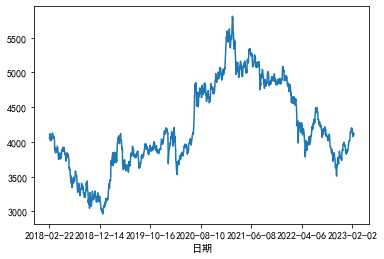

In [89]:
index_zh_a_hist_df["收盘"].plot()

In [90]:
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})
        if str(self.datetime.date(0)) in sell_date.keys(): 
            s_list=sell_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in buy_date.keys(): 
            s_list=buy_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

            
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

In [91]:
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 100000.00
2018-01-03, 买入300354.SZ, 成交量443，成交价40.60
2018-01-03, 买入300211.SZ, 成交量400，成交价45.04
2018-01-03, 买入300126.SZ, 成交量677，成交价26.50
2018-01-03, 买入300442.SZ, 成交量835，成交价21.67
2018-01-03, 买入300093.SZ, 成交量871，成交价20.68
2018-02-14, 卖出300211.SZ, 成交量-400，成交价38.53
2018-02-14, 卖出300442.SZ, 成交量-835，成交价17.59
2018-02-14, 买入300354.SZ, 成交量19，成交价31.57
2018-02-14, 买入300220.SZ, 成交量331，成交价43.67
2018-02-14, 买入300093.SZ, 成交量133，成交价14.65
2018-02-14, 买入300404.SZ, 成交量535，成交价27.23
2018-02-14, 卖出300126.SZ, 成交量-4，成交价21.53
2018-04-04, 卖出300404.SZ, 成交量-535，成交价44.38
2018-04-04, 卖出300220.SZ, 成交量-331，成交价52.17
2018-04-04, 卖出300354.SZ, 成交量-27，成交价44.34
2018-04-04, 买入300093.SZ, 成交量120，成交价16.09
2018-04-04, 买入300092.SZ, 成交量940，成交价19.34
2018-04-04, 买入300211.SZ, 成交量427，成交价42.51
2018-04-04, 买入300126.SZ, 成交量74，成交价24.04
2018-05-22, 卖出300093.SZ, 成交量-1124，成交价15.87
2018-05-22, 买入300354.SZ, 成交量37，成交价37.70
2018-05-22, 买入300126.SZ, 成交量25，成交价22.84
2018-05-22, 买入300330.SZ, 成交量786，成交价22.84
2018-05-22, 卖出3002

2022-08-01, 买入300321.SZ, 成交量54，成交价36.73
2022-08-01, 卖出300594.SZ, 成交量-147，成交价18.78
2022-08-01, 买入300736.SZ, 成交量87，成交价25.38
2022-08-01, 卖出300521.SZ, 成交量-146，成交价23.63
2022-08-01, 卖出300637.SZ, 成交量-67，成交价15.78
2022-09-13, 卖出300321.SZ, 成交量-41，成交价36.67
2022-09-13, 买入300594.SZ, 成交量319，成交价16.92
2022-09-13, 买入300521.SZ, 成交量269，成交价20.56
2022-09-13, 卖出300736.SZ, 成交量-337，成交价28.70
2022-09-13, 买入300637.SZ, 成交量68，成交价15.13
2022-11-01, 买入300321.SZ, 成交量96，成交价32.47
2022-11-01, 买入300594.SZ, 成交量21，成交价15.75
2022-11-01, 卖出300521.SZ, 成交量-35，成交价19.45
2022-11-01, 卖出300736.SZ, 成交量-78，成交价28.29
2022-11-01, 买入300637.SZ, 成交量99，成交价13.90
2022-12-13, 卖出300736.SZ, 成交量-2064，成交价37.85
2022-12-13, 买入300321.SZ, 成交量103，成交价34.74
2022-12-13, 买入300521.SZ, 成交量493，成交价18.90
2022-12-13, 买入300637.SZ, 成交量452，成交价14.32
2022-12-13, 卖出300594.SZ, 成交量-575，成交价20.85
2022-12-13, 买入300126.SZ, 成交量2902，成交价22.52
2023-02-01, 卖出300126.SZ, 成交量-2902，成交价24.07
2023-02-01, 买入300321.SZ, 成交量90，成交价35.42
2023-02-01, 买入300637.SZ, 成交量344，成交价14.02
2023-02-01, 卖出

In [94]:
cash_plot=pd.Series(cash_value)

<AxesSubplot:xlabel='日期'>

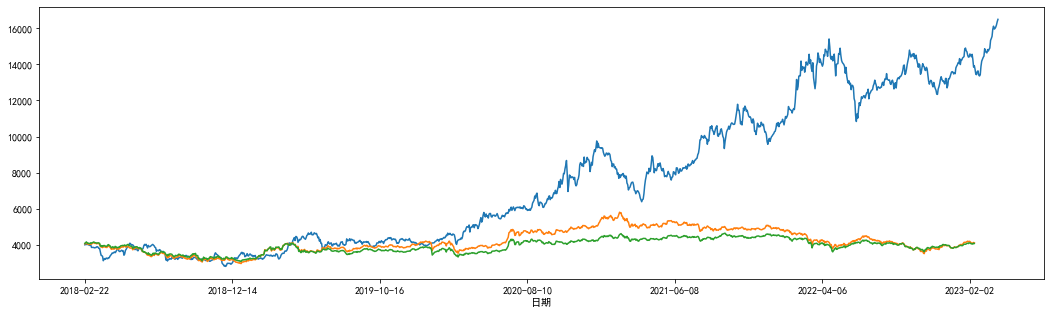

In [109]:
(cash_plot/25).plot(figsize=(18,5))
index_zh_a_hist_df["收盘"].plot()
(index_zh["收盘"]*1.25).plot()

In [98]:
index_zh_a_hist_df["收盘"]

日期
2018-02-22    4052.73
2018-02-23    4071.09
2018-02-26    4118.42
2018-02-27    4058.98
2018-02-28    4023.64
               ...   
2023-02-06    4086.88
2023-02-07    4094.23
2023-02-08    4076.14
2023-02-09    4130.86
2023-02-10    4106.31
Name: 收盘, Length: 1207, dtype: float64

In [99]:
100000/4052.73

24.674725431992755

In [108]:
index_zh["收盘"]*1.25

0       4085.7000
1       4111.2750
2       4161.9625
3       4115.0875
4       4074.2625
          ...    
1202    4048.3750
1203    4060.1125
1204    4040.1375
1205    4087.9750
1206    4075.8375
Name: 收盘, Length: 1207, dtype: float64

In [104]:
#沪深300
index_zh = ak.index_zh_a_hist(symbol="000001", period="daily", start_date="20180222", end_date="20230210")
print(index_zh)

              日期       开盘       收盘       最高       最低        成交量           成交额  \
0     2018-02-22  3237.57  3268.56  3269.92  3234.11  138730445  1.573039e+11   
1     2018-02-23  3275.43  3289.02  3294.13  3258.49  145790369  1.595025e+11   
2     2018-02-26  3307.29  3329.57  3335.99  3281.61  188568602  2.133330e+11   
3     2018-02-27  3328.67  3292.07  3328.67  3284.63  174219369  2.043944e+11   
4     2018-02-28  3264.06  3259.41  3277.83  3239.84  151043535  1.802338e+11   
...          ...      ...      ...      ...      ...        ...           ...   
1202  2023-02-06  3244.70  3238.70  3250.35  3226.21  267053107  3.491273e+11   
1203  2023-02-07  3245.23  3248.09  3250.03  3233.83  250946450  3.212576e+11   
1204  2023-02-08  3251.50  3232.11  3257.11  3230.44  234530481  2.933327e+11   
1205  2023-02-09  3227.73  3270.38  3270.38  3225.77  254754529  3.517608e+11   
1206  2023-02-10  3266.44  3260.67  3269.99  3247.23  260626926  3.417499e+11   

        振幅   涨跌幅    涨跌额   换